In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Set manual seed for reproducibility
torch.manual_seed(1)

In [13]:
# Function to load MNIST data
def load_data(train_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=True)
    return train_loader, test_loader

In [14]:
# CNN model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.adap_pool2d = nn.AdaptiveAvgPool2d((5, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.adap_pool2d(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
# Training and evaluation functions
def train(model, optimizer, train_loader, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [16]:
def calculate_loss_accuracy(model, loader, loss_fn):
    model.eval()
    loss_total, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = loss_fn(output, target)
            loss_total += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return loss_total / len(loader), correct / total


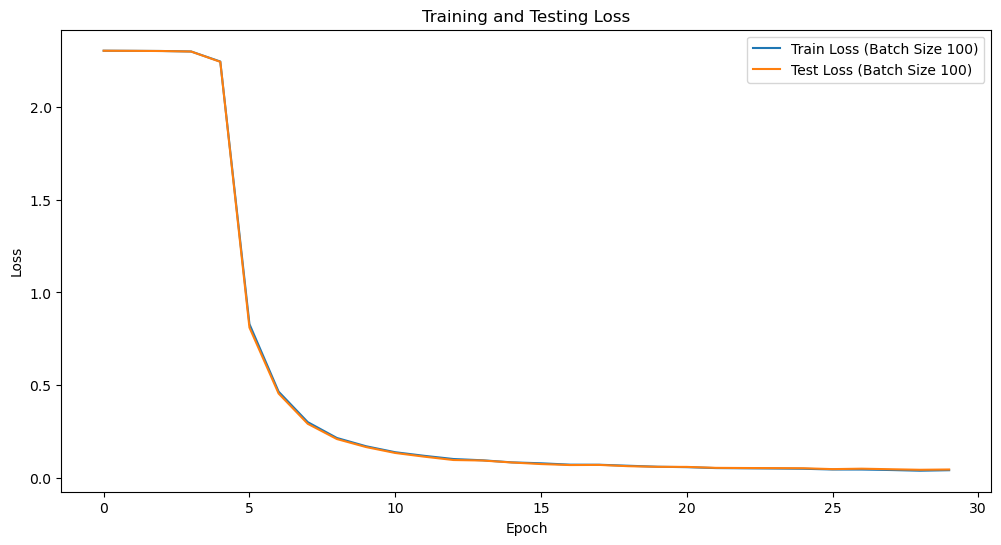

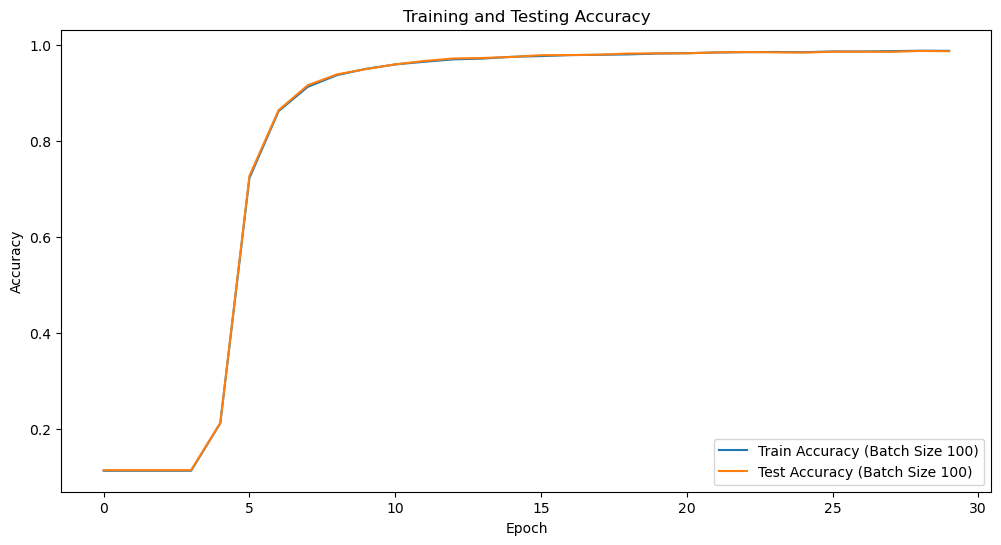

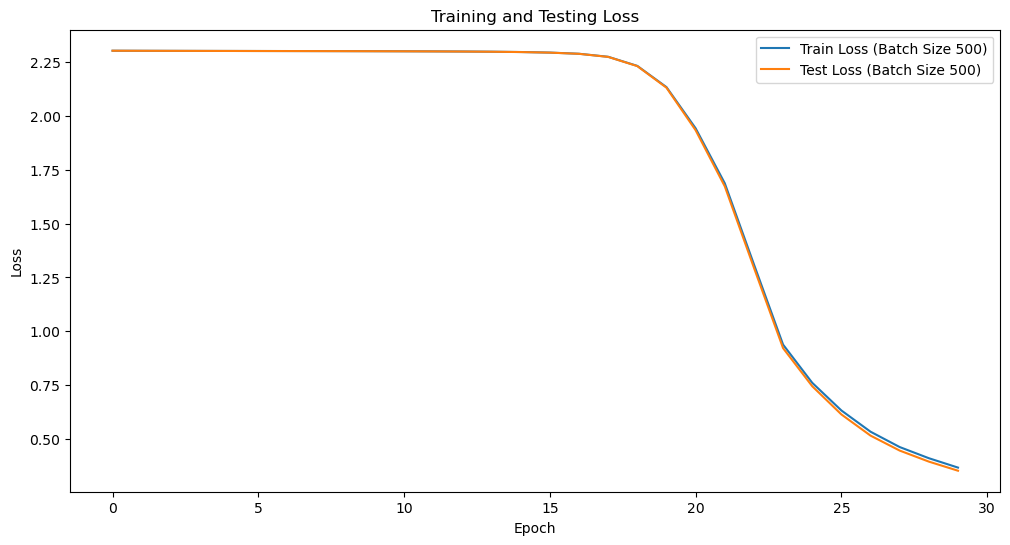

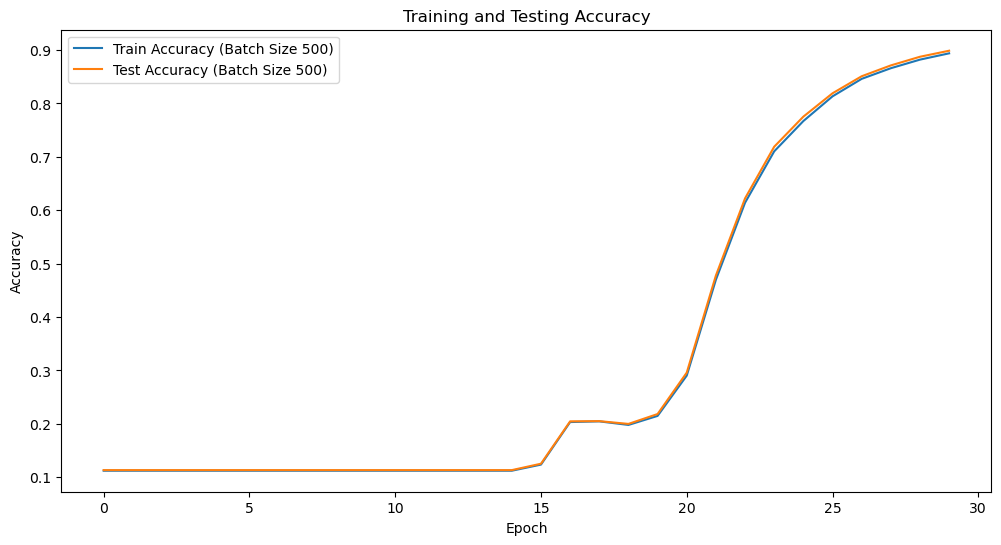

In [17]:
# Function to compute and compare models with different batch sizes
def compute_and_compare(batch_sizes):
    epochs = 30
    loss_fn = nn.CrossEntropyLoss()

    for batch_size in batch_sizes:
        train_loader, test_loader = load_data(batch_size, batch_size)
        model = CNN()
        optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
        
        train_losses, test_losses, train_accs, test_accs = [], [], [], []
        for epoch in range(epochs):
            train(model, optimizer, train_loader, loss_fn)
            train_loss, train_acc = calculate_loss_accuracy(model, train_loader, loss_fn)
            test_loss, test_acc = calculate_loss_accuracy(model, test_loader, loss_fn)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
        
        # Plot training and testing metrics
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label=f'Train Loss (Batch Size {batch_size})')
        plt.plot(test_losses, label=f'Test Loss (Batch Size {batch_size})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Testing Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(train_accs, label=f'Train Accuracy (Batch Size {batch_size})')
        plt.plot(test_accs, label=f'Test Accuracy (Batch Size {batch_size})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Testing Accuracy')
        plt.legend()
        plt.show()

# Example usage
compute_and_compare([100, 500])